### Build and save noise-free synthetics

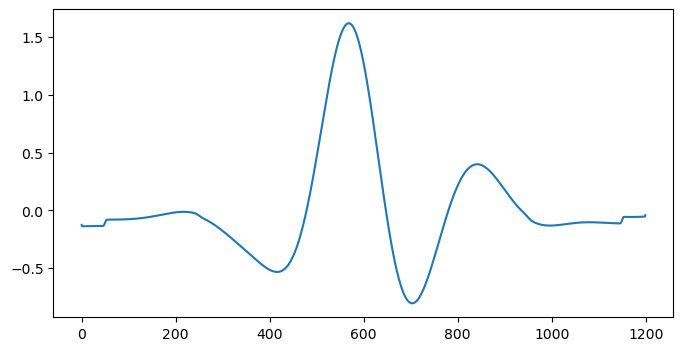

In [ ]:
import os, pickle
import numpy as np
import matplotlib.pyplot as plt
from sharp_ss.model import Model, Prior
from sharp_ss.forward import create_G_from_model, convolve_P_G

# Model parameters
modname = 'mod01'
loc = [5, 25] # seconds
amp = [-0.15, 0.02]
wid = [1, 3] # seconds

# Prior parameters
stdP = 0.1
widRange = (0.1, 5) # seconds

# filedir = "H:\My Drive\Research\SharpSSPy"
filedir = "/Users/evanzhang/zzq@umd.edu - Google Drive/My Drive/Research/SharpSSPy"

# Load P(arent) from ocean stack
tmp = np.loadtxt(os.path.join(filedir, 'misc/ocean_stack.csv'), delimiter=",", skiprows=1)
Ptime = tmp[:,0]
P = tmp[:,1]
dt = Ptime[1] - Ptime[0]

# Define prior and model objects
prior = Prior(tlen=Ptime[-1], stdP=stdP, dt=dt, widRange=widRange)
model = Model(Nphase=2, loc=np.array(loc), amp=np.array(amp), wid=np.array(wid), sig=0, nc1=0, nc2=0)

# Build G and D(aughter)
G = create_G_from_model(model=model, prior=prior)
D = convolve_P_G(P, G)

# Visualize
plt.figure(figsize=(8, 4))
plt.plot(D)
plt.show()

# Save
savedir = os.path.join(filedir, 'data', modname)
os.makedirs(savedir, exist_ok=True)
np.savez(os.path.join(savedir, 'data.npz'), P=P, D=D, G=G)
with open(os.path.join(savedir, 'prior.pkl'), "wb") as f:
    pickle.dump(prior, f)
with open(os.path.join(savedir, 'model.pkl'), "wb") as f:
    pickle.dump(model, f)
with open(os.path.join(savedir, 'model.txt'), "w") as f:
    f.write(f"# Model parameters\n")
    f.write(f"modname = '{modname}'\n")
    f.write(f"loc = {loc}  # seconds\n")
    f.write(f"amp = {amp}\n")
    f.write(f"wid = {wid}  # seconds\n")


### Add noise from covariance matrix

In [ ]:
import os
import numpy as np
import pickle

reload = False
noise_ct = 50

# filedir = "H:\My Drive\Research\SharpSSPy"
filedir = "/Users/evanzhang/zzq@umd.edu - Google Drive/My Drive/Research/SharpSSPy"

# Load synthetic data from file, or just continue from previous cell
if reload:
    modname = 'mod01'
    data = np.load(os.path.join(filedir, 'data', modname, 'data.npz'))
    P = data["P"]
    D = data["D"]
    G = data["G"]
    with open(os.path.join(savedir, 'prior.pkl'), "rb") as f:
        prior = pickle.load(f)
    with open(os.path.join(savedir, 'model.pkl'), "rb") as f:
        model = pickle.load(f)

# Output directory
output_dir = os.path.join(filedir, 'data', modname)
os.makedirs(output_dir, exist_ok=True)

# Noise parameters from Kolb and Lekic (2014)
lambda_ = 0.2
omega0 = 4.4

# Time vector
time = np.arange(len(P)) * prior.dt
lenT = len(time)

# Construct covariance matrix
CovMat = np.zeros((lenT, lenT))
for i in range(lenT):
    for j in range(lenT):
        tdiff = abs(time[j] - time[i])
        CovMat[i, j] = np.exp(-lambda_ * tdiff) * np.cos(lambda_ * omega0 * tdiff)

# Cholesky decomposition for correlated noise
L = np.linalg.cholesky(CovMat)

# Matrix to hold all noisy traces
all_noisy_traces = np.zeros((lenT, noise_ct))

# Generate noise and store in matrix
for inoise in range(noise_ct):
    raw_noise = L @ np.random.randn(lenT)
    raw_noise = 2 * (raw_noise - raw_noise.min()) / (raw_noise.max() - raw_noise.min()) - 1  # Normalize to [-1, 1]
    this_noise = 0.1 * raw_noise
    D_noisy = D + this_noise
    all_noisy_traces[:, inoise] = D_noisy

# Save to CSV
csv_path = os.path.join(output_dir, "data_noisy.csv")
np.savetxt(csv_path, all_noisy_traces, delimiter=",")

### Evaluate denoised result

#### Plot log likelihood for denoised dataset

##### Archive: different color for each DLmod (hard to read)

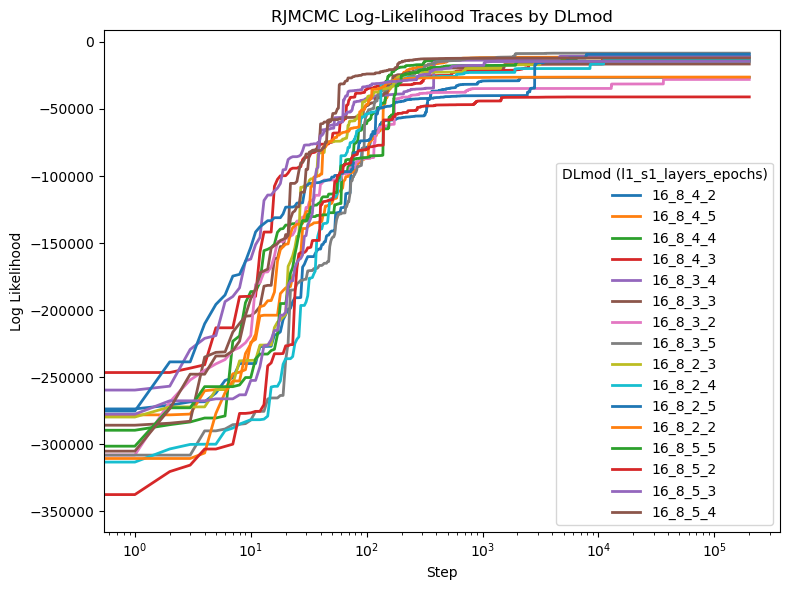

In [37]:
# archive: different color for each DLmod (hard to read)
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# === Settings ===
filedir = "/Users/evanzhang/zzq@umd.edu - Google Drive/My Drive/Research/SharpSSPy"
modname = "mod01_synDL"
use_log_x = True
avg_DLmod = True
xlim = None # set to None to disable

run_base = os.path.join(filedir, "run", modname)

# Color map for distinct DLmod groups
colors = plt.cm.tab10.colors
dlmod_to_color = {}
color_idx = 0

# Store traces: {DLname: [list of logL arrays]}
dlmod_traces = defaultdict(list)

# Walk through run directory
for root, dirs, files in os.walk(run_base):
    if "logL.txt" in files:
        parts = root.split(os.sep)
        try:
            DLname = parts[parts.index(modname) + 1]  # "16_8_2_5"
            chain = parts[-1]                         # "chain_0", etc.
        except (ValueError, IndexError):
            continue

        # Load trace
        logL_path = os.path.join(root, "logL.txt")
        logL = np.loadtxt(logL_path)

        # Track and group
        dlmod_traces[DLname].append((chain, logL))

        # Assign color if new DLmod
        if DLname not in dlmod_to_color:
            dlmod_to_color[DLname] = colors[color_idx % len(colors)]
            color_idx += 1

# === Plot ===
fig, ax = plt.subplots(figsize=(8, 6))

for DLname, chains in dlmod_traces.items():
    color = dlmod_to_color[DLname]

    if avg_DLmod:
        # Unpack logL arrays
        logLs = [logL for (_, logL) in chains] if isinstance(chains[0], tuple) else chains
        min_len = min(len(x) for x in logLs)
        traces_trimmed = np.array([x[:min_len] for x in logLs])

        avg_trace = np.mean(traces_trimmed, axis=0)
        std_trace = np.std(traces_trimmed, axis=0)
        steps = np.arange(len(avg_trace))

        ax.plot(steps, avg_trace, label=DLname, color=color, lw=2)
        # ax.fill_between(steps, avg_trace - std_trace, avg_trace + std_trace,
        #                 color=color, alpha=0.25, linewidth=0)
    else:
        for chain_id, logL in chains:
            steps = np.arange(len(logL))
            ax.plot(steps, logL, label=f"{DLname} - {chain_id}", color=color, alpha=0.7)

if use_log_x:
    ax.set_xscale("log")
if xlim is not None:
    ax.set_xlim(xlim)

# Legend with one entry per DLmod
handles = [plt.Line2D([0], [0], color=color, lw=2, label=dl) for dl, color in dlmod_to_color.items()]
ax.legend(handles=handles, title="DLmod (l1_s1_layers_epochs)", loc="lower right")

ax.set_xlabel("Step")
ax.set_ylabel("Log Likelihood")
ax.set_title("RJMCMC Log-Likelihood Traces by DLmod")
fig.tight_layout()
plt.show()


##### Current code

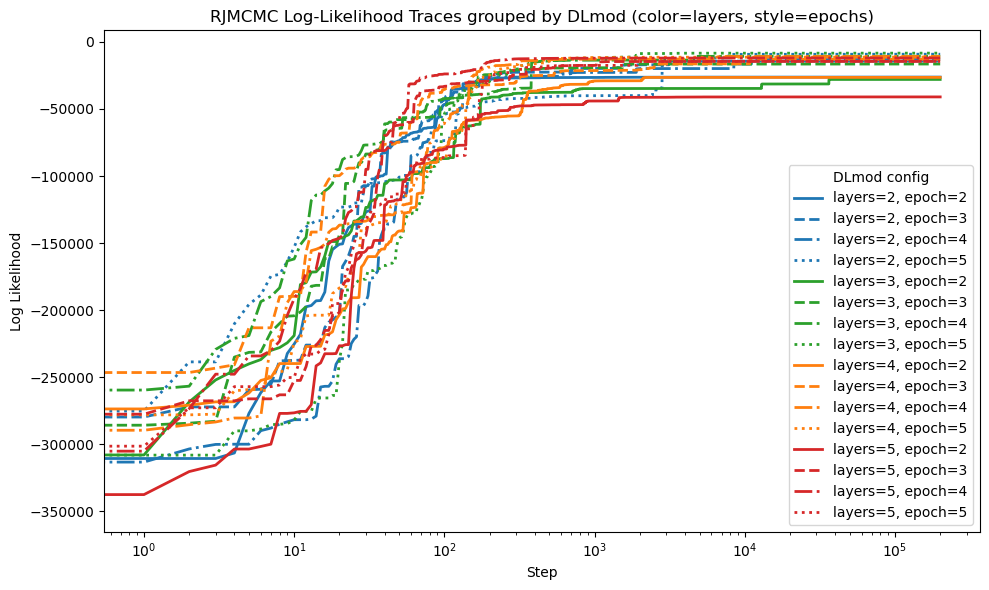

In [39]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# === Settings ===
filedir = "/Users/evanzhang/zzq@umd.edu - Google Drive/My Drive/Research/SharpSSPy"
modname = "mod01_synDL"
use_log_x = True
avg_DLmod = True
xlim = None  # set to None to disable

run_base = os.path.join(filedir, "run", modname)

# Define color per num_layers, linestyle per epoch
layer_colors = {2: "tab:blue", 3: "tab:green", 4: "tab:orange", 5: "tab:red"}
epoch_linestyles = {2: "solid", 3: "dashed", 4: "dashdot", 5: "dotted"}

# Store traces: {(num_layers, epoch): [logL arrays]}
dlmod_traces = defaultdict(list)

# Walk through run directory
for root, dirs, files in os.walk(run_base):
    if "logL.txt" in files:
        parts = root.split(os.sep)
        try:
            DLname = parts[parts.index(modname) + 1]  # "16_8_2_5"
            chain = parts[-1]
        except (ValueError, IndexError):
            continue

        # Parse layers and epoch
        try:
            _, _, num_layers, epoch = map(int, DLname.split("_"))
        except Exception as e:
            print(f"Skipping {DLname}: {e}")
            continue

        # Load trace
        logL_path = os.path.join(root, "logL.txt")
        logL = np.loadtxt(logL_path)

        # Track and group
        dlmod_traces[(num_layers, epoch)].append(logL)

# === Plot ===
fig, ax = plt.subplots(figsize=(10, 6))

for (num_layers, epoch), logLs in sorted(dlmod_traces.items()):
    color = layer_colors.get(num_layers, "black")
    linestyle = epoch_linestyles.get(epoch, "solid")

    # Average across chains
    min_len = min(len(x) for x in logLs)
    traces_trimmed = np.array([x[:min_len] for x in logLs])
    avg_trace = np.mean(traces_trimmed, axis=0)
    steps = np.arange(len(avg_trace))

    label = f"layers={num_layers}, epoch={epoch}"
    ax.plot(steps, avg_trace, label=label, color=color, linestyle=linestyle, lw=2)

if use_log_x:
    ax.set_xscale("log")
if xlim is not None:
    ax.set_xlim(xlim)

# Legend
ax.legend(title="DLmod config", loc="lower right")
ax.set_xlabel("Step")
ax.set_ylabel("Log Likelihood")
ax.set_title("RJMCMC Log-Likelihood Traces grouped by DLmod (color=layers, style=epochs)")
fig.tight_layout()
plt.show()


#### Denoised D vs. Clean D

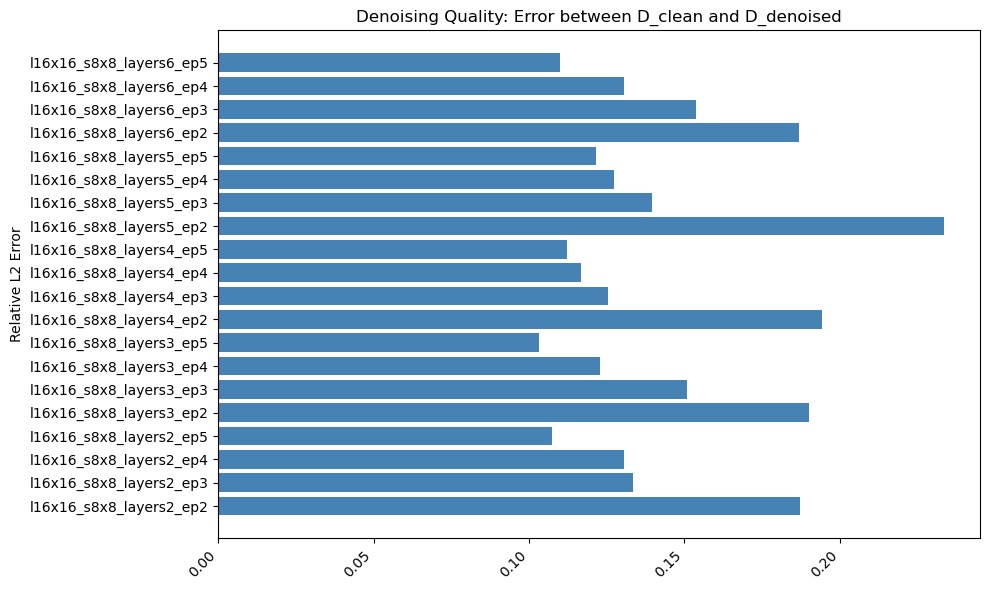

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt

# === Load clean D ===
# filedir = "H:\My Drive\Research\SharpSSPy"
filedir = "/Users/evanzhang/zzq@umd.edu - Google Drive/My Drive/Research/SharpSSPy"
modname = 'mod01'
datadir = os.path.join(filedir, 'data', modname)
D_clean = np.load(os.path.join(datadir, 'data.npz'))["D"]

# === Loop over denoised files ===
denoise_dir = os.path.join(datadir, 'DL_denoise')
dlmod_errors = {}

for fname in os.listdir(denoise_dir):
    if not fname.endswith(".csv"):
        continue

    # Parse DLmod name from filename
    fname_core = fname.replace("data_denoised_", "").replace(".csv", "")
    DLmod = fname_core  # e.g., "l1x2_s3x3_layers4_ep200"

    # Load denoised data
    fpath = os.path.join(denoise_dir, fname)
    D_denoised = np.loadtxt(fpath, delimiter=',')

    # === Error metric ===
    if D_denoised.shape[0] != D_clean.shape[0]:
        print(f"Skipping {fname}: shape mismatch")
        continue

    # Compute relative L2 error for each denoised trace, then average
    rel_l2_errors = np.linalg.norm(D_denoised - D_clean[:, None], axis=0) / np.linalg.norm(D_clean)
    avg_rel_l2_error = np.mean(rel_l2_errors)
    dlmod_errors[DLmod] = avg_rel_l2_error

# === Sort by DLmod for consistent plotting ===
sorted_dlmods = sorted(dlmod_errors.keys())
errors = [dlmod_errors[dl] for dl in sorted_dlmods]

# === Plot ===
plt.figure(figsize=(10, 6))
plt.barh(sorted_dlmods, errors, color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Relative L2 Error")
plt.title("Denoising Quality: Error between D_clean and D_denoised")
plt.tight_layout()
plt.show()

#### Recovered model vs. true model

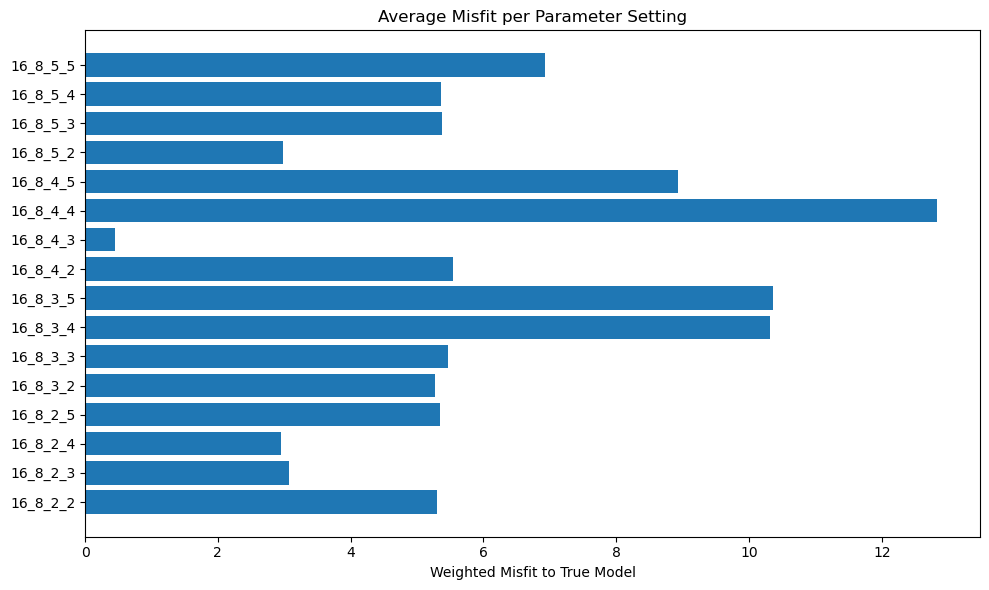

In [33]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# === Configuration ===
modname = 'mod01_synDL'
base_dir = f"/Users/evanzhang/zzq@umd.edu - Google Drive/My Drive/Research/SharpSSPy/run/{modname}"

true_model = {
    'loc': np.array([5.0, 25.0]),
    'amp': np.array([-0.15, 0.02]),
    'wid': np.array([1.0, 3.0])
}
weights = {
    'loc': 1.0,
    'amp': 0.2,
    'wid': 0.2
}

def compute_weighted_misfit(model, true_model, weights):
    misfit = 0.0
    for key in ['loc', 'amp', 'wid']:
        mval = np.array(getattr(model, key))
        tval = true_model[key]
        w = weights[key]
        if len(mval) != len(tval):
            raise ValueError(f"Length mismatch in {key}: model={mval}, true={tval}")
        misfit += w * np.mean(np.abs(mval - tval))
    return misfit

# === Traverse parameter setting folders ===
results = {}
for setting in sorted(os.listdir(base_dir)):
    setting_path = os.path.join(base_dir, setting)
    if not os.path.isdir(setting_path):
        continue

    setting_misfits = []
    for run in os.listdir(setting_path):
        run_path = os.path.join(setting_path, run)
        if not os.path.isdir(run_path):
            continue

        for chain in os.listdir(run_path):
            chain_path = os.path.join(run_path, chain)
            pkl_file = os.path.join(chain_path, "ensemble.pkl")
            if not os.path.isfile(pkl_file):
                continue

            try:
                with open(pkl_file, 'rb') as f:
                    ensemble = pickle.load(f)
                misfits = [compute_weighted_misfit(m, true_model, weights) for m in ensemble]
                avg_misfit = np.mean(misfits)
                setting_misfits.append(avg_misfit)
            except Exception as e:
                print(f"Failed to process {pkl_file}: {e}")

    if setting_misfits:
        results[setting] = np.mean(setting_misfits)

# === Plot ===
plt.figure(figsize=(10, 6))
keys = list(results.keys())
values = [results[k] for k in keys]
plt.barh(keys, values)
plt.xlabel("Weighted Misfit to True Model")
plt.title("Average Misfit per Parameter Setting")
plt.tight_layout()
plt.show()
